# Curves And Splines

Notebook by Jerome Eippers, 2024

# Curve Types

* Approximation curve (the curve does not go through the points)
    * Bezier Curve
    * Cubic BSpline  
    
* Interpolation curve (the curve goes through all the points)
    * Hermite Curve 
    * Cardinal Spline


In [1]:
%matplotlib widget
import numpy as np
from ipywidgets import widgets, interact
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.special import comb
import sympy as sym
from scipy.optimize import minimize

mpl.rc('figure', max_open_warning = 0)

# Bezier Curve

## De Casteljau's algorithm

$$
\begin{align}
\mathbf{B}_{\mathbf{P}_0} &= \mathbf{P}_0 \\
\mathbf{B}(t) &= \mathbf{B}_{\mathbf{P}_0\mathbf{P}_1\ldots\mathbf{P}_n}(t) = (1-t)\mathbf{B}_{\mathbf{P}_0\mathbf{P}_1\ldots\mathbf{P}_{n-1}}(t) + t\mathbf{B}_{\mathbf{P}_1\mathbf{P}_2\ldots\mathbf{P}_n}(t)
\end{align}
$$


interactive(children=(FloatSlider(value=0.0, description='x', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.draw_bezier(x)>

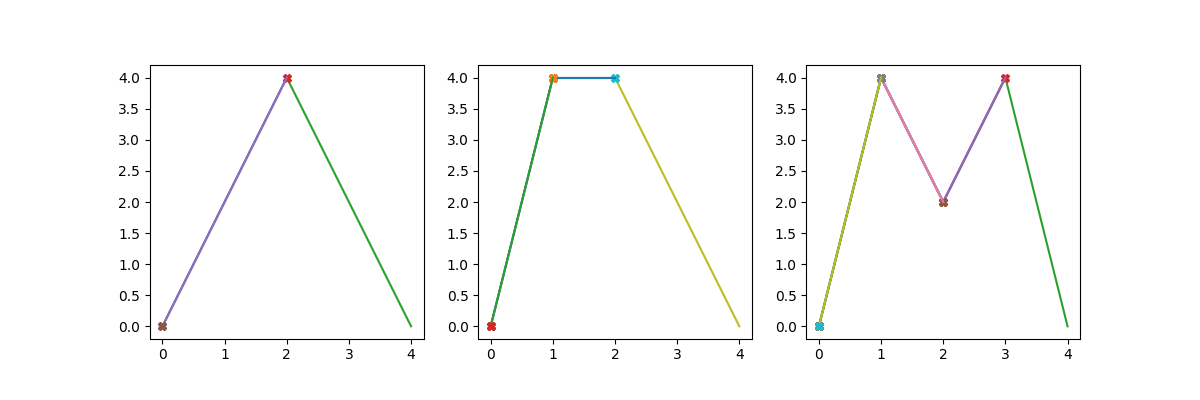

In [3]:
P3 = np.array([
    [0,0],
    [2,4],
    [4,0]
])

P4 = np.array([
    [0,0],
    [1,4],
    [2,4],
    [4,0]
])

P5 = np.array([
    [0,0],
    [1,4],
    [2,2],
    [3,4],
    [4,0]
])


def castlejau(t, P, ax_draw=None):
    if P.shape[0] == 1:
        return P
    
    a = castlejau(t, P[:-1], ax_draw)
    b = castlejau(t, P[1:], ax_draw)
    linear = a * (1.0-t)[..., np.newaxis] + b * t[..., np.newaxis]
    
    if ax_draw is not None:
        ax_draw.plot([a[:, 0], b[:, 0]], [a[:, 1], b[:, 1]], '-')
        ax_draw.plot(linear[:, 0], linear[:, 1], 'X')
        
    return linear


fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')


def draw_bezier(x):
    ax1.cla()
    ax2.cla()
    ax3.cla()
    
    t_inter = np.array([x])
    t = np.linspace(0,x,101)
    
    # draw intermediate
    castlejau(t_inter, P3, ax1)
    castlejau(t_inter, P4, ax2)
    castlejau(t_inter, P5, ax3)
    
    # compute the bezier
    bezier = castlejau(t, P3)
    ax1.plot(bezier[:, 0], bezier[:, 1], '--', c='black')
    
    bezier = castlejau(t, P4)
    ax2.plot(bezier[:, 0], bezier[:, 1], '--', c='black')
    
    bezier = castlejau(t, P5)
    ax3.plot(bezier[:, 0], bezier[:, 1], '--', c='black')
    
    
interact(
    draw_bezier, 
    x= widgets.FloatSlider(min=0, max=1, step=0.01, value=0)
)

## Bernstein polynomial

The $\textbf{Bernstein polynomial}$ of degree $n$ is defined as:
$$B_{n,k}(t) = \binom{n}{k} t^k (1 - t)^{n - k}, \quad \text{for } k = 0, 1, 2, \ldots, n$$

Where:
- $n$ is the degree of the Bernstein polynomial.
- $k$ is the index of the Bernstein polynomial, ranging from 0 to $n$.
- $t$ is a parameter that varies between 0 and 1.
- $\binom{n}{k}$ represents the binomial coefficient, given by $\frac{n!}{k!(n-k)!}$.


In [4]:
def bernstein_basis(n, k, t):
    return comb(n, k) * (t**k) * ((1 - t)**(n - k))

interactive(children=(IntSlider(value=3, description='n', max=12, min=1), Output()), _dom_classes=('widget-int…

<function __main__.draw_basis(n)>

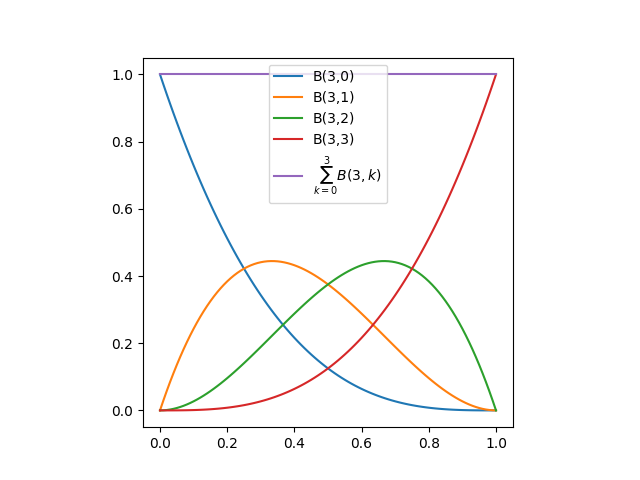

In [6]:
fig2, (ax4) = plt.subplots(1, 1)

ax4.set_aspect('equal')
t = np.linspace(0,1,101)

def draw_basis(n):
    ax4.cla()
    for k in range(n + 1):
        y = bernstein_basis(n, k, t)
        ax4.plot(t, y, label=f'B({n},{k})')
        
    y = np.sum(np.array([bernstein_basis(n, k, t) for k in range(n+1)]), axis=0)
    ax4.plot(t, y, label=f'$\\sum_{{k=0}}^{n}B({n},k)$')
    ax4.legend()

interact(
    draw_basis, 
    n= widgets.IntSlider(min=1, max=12, value=3)
)

### Bernstein for approximation

interactive(children=(IntSlider(value=1, description='n', max=16, min=1), Output()), _dom_classes=('widget-int…

<function __main__.draw_approximation(n)>

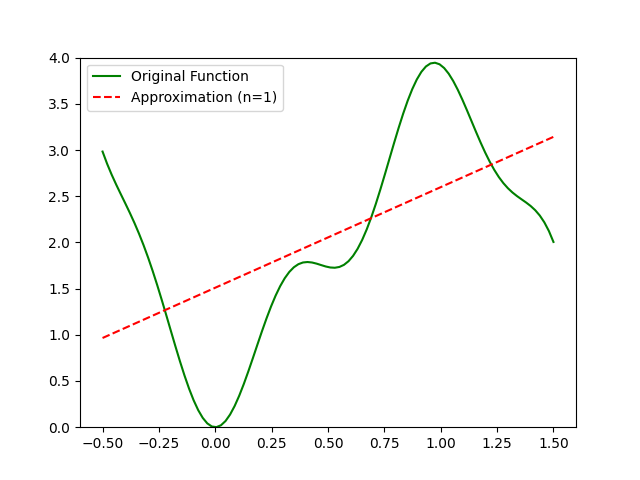

In [7]:
# Define the function to be approximated
def f(x):
    return -5*x**3 + 8*x**2 + np.sin(x*5)**2

# Parameters for the interval [a, b] and degree n
a = -.5
b = 1.5

# Plot the original function and the approximation
fig3, (ax5) = plt.subplots(1, 1)

def draw_approximation(n):

    # Create a set of sample points
    num_samples = 100
    x_samples = np.linspace(a, b, num_samples)
    y_samples = f(x_samples)

    # Create the matrix for the approximation
    X = np.array([bernstein_basis(n, k, (x_samples - a) / (b - a)) for k in range(n + 1)]).swapaxes(0,1)

    # Use the least squares method to find coefficients
    coefficients, residuals, _, _ = np.linalg.lstsq(X, y_samples, rcond=None)

    # Create the approximation function
    def approximate_function(x, coefficients, a, b):
        t = (x - a) / (b - a)
        result = sum(coefficients[k] * bernstein_basis(n, k, t) for k in range(n + 1))
        return result

    # Generate points for the approximation
    y_values = approximate_function(x_samples, coefficients, a, b)

    ax5.cla()
    ax5.plot(x_samples, y_samples, label='Original Function', color='green')
    ax5.plot(x_samples, y_values, '--', label=f'Approximation (n={n})', color='red')
    ax5.set_ylim([0, 4])
    ax5.legend()

interact(
    draw_approximation, 
    n= widgets.IntSlider(min=1, max=16)
)

### Bernstein for Bezier Curve

A $\textbf{Bezier curve}$ is defined using Bernstein polynomials as follows:

For a Bezier curve with $n$ control points $P_0, P_1, \ldots, P_n$, the curve is given by:
$$B(t) = \sum_{i=0}^{n} P_i \cdot B_{n,i}(t), \quad \text{for } 0 \leq t \leq 1$$

Where:
- $B(t)$ represents the Bezier curve at parameter $t$.
- $P_i$ are the control points of the curve.
- $B_{n,i}(t)$ are the Bernstein basis functions of degree $n$.

In [8]:
def bezier(P, t):
    n = P.shape[0]-1
    return np.sum(np.array([bernstein_basis(n, k, t)[..., np.newaxis] * P[k, ...] for k in range(n + 1)]), axis=0)

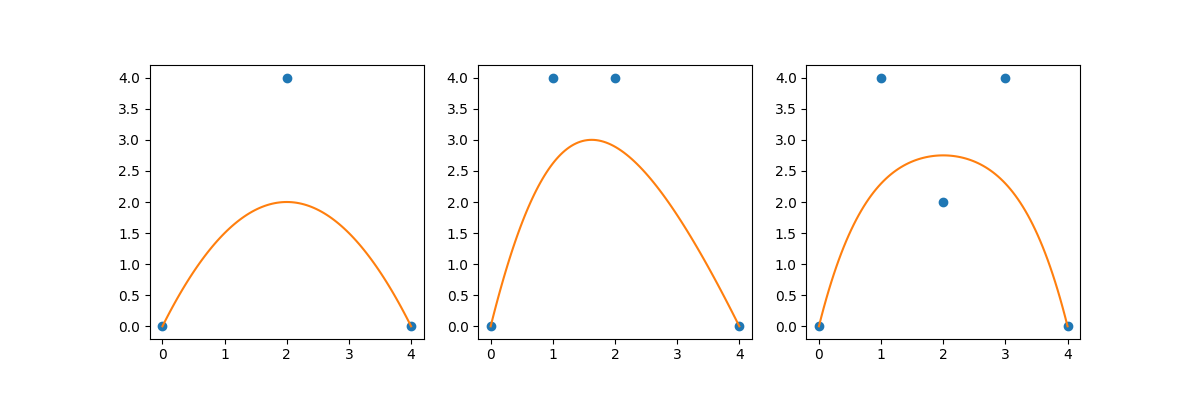

In [9]:
t = np.linspace(0,1,101)

fig4, (ax6, ax7, ax8) = plt.subplots(1, 3, figsize=(12,4))

ax6.set_aspect('equal')
ax7.set_aspect('equal')
ax8.set_aspect('equal')

b3 = bezier(P3, t)
b4 = bezier(P4, t)
b5 = bezier(P5, t)
ax6.plot(P3[:,0], P3[:,1], 'o')
ax6.plot(b3[:, 0], b3[:, 1])
ax7.plot(P4[:,0], P4[:,1], 'o')
ax7.plot(b4[:, 0], b4[:, 1])
ax8.plot(P5[:,0], P5[:,1], 'o')
ax8.plot(b5[:, 0], b5[:, 1])

### Link between De Casteljau and Bernstein.

In [10]:
P1, P2, P3, P4, t = sym.symbols('P1 P2 P3 P4 t')
A1, A2, A3, B1, B2, C1 = sym.symbols('A1 A2 A3 B1 B2 C1', cls=sym.Function)

# De Castlejau formula
A1 = (1 - t)*P1 + t*P2
A2 = (1 - t)*P2 + t*P3
A3 = (1 - t)*P3 + t*P4

B1 = (1 - t)*A1 + t*A2
B2 = (1 - t)*A2 + t*A3

C1 = (1 - t)*B1 + t*B2

C1 = sym.expand(C1)
C1 = sym.collect(C1, (P1, P2, P3, P4))
print('De Castlejau :')
display(C1)


# Bernstein formula
Bern =  (sym.binomial(3,0) * (t**0) * ((1 - t)**(3 - 0)) * P1) +\
        (sym.binomial(3,1) * (t**1) * ((1 - t)**(3 - 1)) * P2) +\
        (sym.binomial(3,2) * (t**2) * ((1 - t)**(3 - 2)) * P3) +\
        (sym.binomial(3,3) * (t**3) * ((1 - t)**(3 - 3)) * P4)

Bern = sym.expand(Bern)
Bern = sym.collect(Bern, (P1, P2, P3, P4))

print('Bernstein :')
display(Bern)

De Castlejau :


P1*(-t**3 + 3*t**2 - 3*t + 1) + P2*(3*t**3 - 6*t**2 + 3*t) + P3*(-3*t**3 + 3*t**2) + P4*t**3

Bernstein :


P1*(-t**3 + 3*t**2 - 3*t + 1) + P2*(3*t**3 - 6*t**2 + 3*t) + P3*(-3*t**3 + 3*t**2) + P4*t**3

In [11]:
Mb = sym.MatrixSymbol('Mb', 4, 4)
T = sym.MatrixSymbol('T', 1, 4)
Pb = sym.MatrixSymbol('Pb', 4, 1)


vMb = sym.Matrix([
    [-1, 3, -3, 1], 
    [3, -6, 3, 0],
    [-3, 3, 0, 0],
    [1, 0, 0, 0]
])

vT = sym.Matrix([t**3, t**2, t, 1]).T
vPb = sym.Matrix([P1, P2, P3, P4])

B = T*Mb*Pb
B.subs({Mb: vMb, T: vT, Pb: vPb})

Matrix([[t**3, t**2, t, 1]])*Matrix([
[-1,  3, -3, 1],
[ 3, -6,  3, 0],
[-3,  3,  0, 0],
[ 1,  0,  0, 0]])*Matrix([
[P1],
[P2],
[P3],
[P4]])

In [12]:
vT * vMb * vPb

Matrix([[P1*(-t**3 + 3*t**2 - 3*t + 1) + P2*(3*t**3 - 6*t**2 + 3*t) + P3*(-3*t**3 + 3*t**2) + P4*t**3]])

## Rational Bezier Curve

We can give a weight to each point, to push the curve more toward or away of that point.

$$B(t) = \frac{\sum_{i=0}^{n} P_i \cdot w_i \cdot B_{n,i}(t)}{\sum_{i=0}^{n} w_i \cdot B_{n,i}(t)}, \quad \text{for } 0 \leq t \leq 1$$

In [13]:
def rational_bezier(P, w, t):
    n = P.shape[0]-1
    v = np.sum(np.array([bernstein_basis(n, k, t)[..., np.newaxis] * P[k, ...] * w[k] for k in range(n + 1)]), axis=0)
    d = np.sum(np.array([bernstein_basis(n, k, t)[..., np.newaxis] * w[k] for k in range(n + 1)]), axis=0)
    return v/d

## Multiple Curves back to back.

To build a bezier spline we just append several curves back to back with the last point of the previous bezier being the first point of the next bezier.

In [14]:
def cubic_bezier(P, t):
    M = np.array([[-1, 3, -3, 1], [3, -6, 3, 0],[-3, 3, 0, 0],[1, 0, 0, 0]])
    P = np.dot(M, P)
    return np.dot(np.column_stack([t**3, t**2, t, np.ones_like(t)]), P)

def cubic_bezier_spline(P, t):
    segment = int((P.shape[0]-1)/3)
    output = np.zeros([t.shape[0], P.shape[1]])
    index = 0
    for s in range(segment):
        where = np.logical_and(t >= s, t <= s+1)
        output[where, :] = cubic_bezier(P[index:index+4, ...], t[where] - s)
        index += 3
    return output

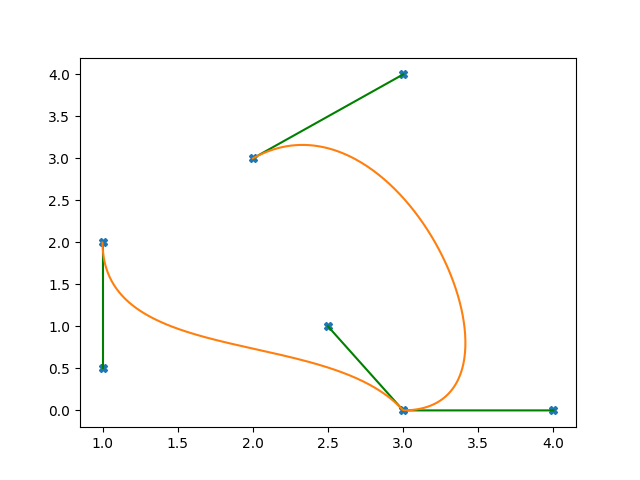

In [15]:
P_spline = np.array([
    [1,2],
    [1,0.5],
    [2.5,1],
    [3,0],
    [4,0],
    [3,4],
    [2,3],
])

bez = cubic_bezier_spline(P_spline, np.linspace(0,2, 400))

fig5, (ax9) = plt.subplots(1, 1)

ax9.plot(P_spline[:,0], P_spline[:,1], 'X')
ax9.plot(P_spline.T[0, [0,1]], P_spline.T[1, [0,1]], c='green')
ax9.plot(P_spline.T[0, [2,3,4]], P_spline.T[1, [2,3,4]], c='green')
ax9.plot(P_spline.T[0, [5,6]], P_spline.T[1, [5,6]], c='green')
ax9.plot(bez[:, 0], bez[:, 1])


# Why focusing on Cubic?

In animation we use curves most of the time to do interpolation of keyframes, so we want the simplest form of curve that can match our animation.

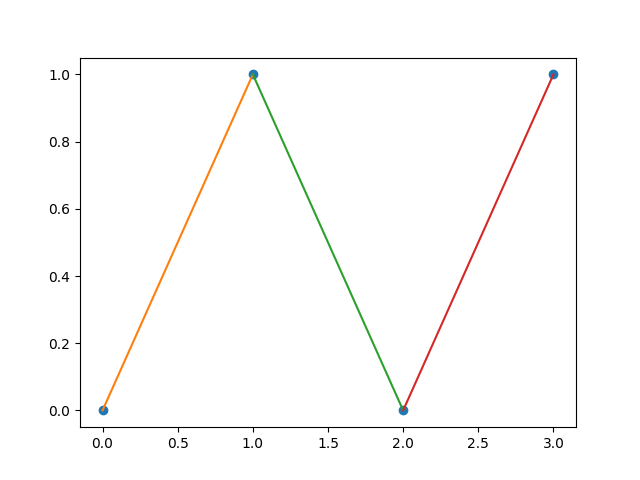

In [16]:
x = np.linspace(0,1,50)

fig6, (ax10) = plt.subplots(1, 1)

ax10.plot([0,1,2,3], [0,1,0,1], 'o')
ax10.plot(x, x)
ax10.plot(x+1, -x+1)
ax10.plot(x+2, x)

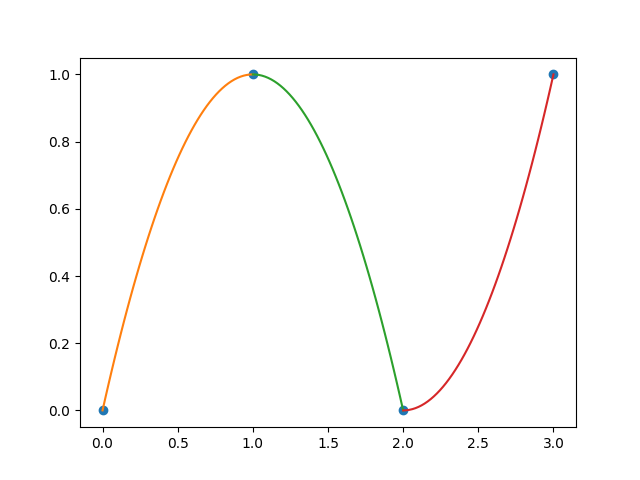

In [17]:
y2p = x**2

fig7, (ax11) = plt.subplots(1, 1)

ax11.plot([0,1,2,3], [0,1,0,1], 'o')
ax11.plot(-x+1, 1-y2p)
ax11.plot(x+1, 1-y2p)
ax11.plot(x+2, y2p)

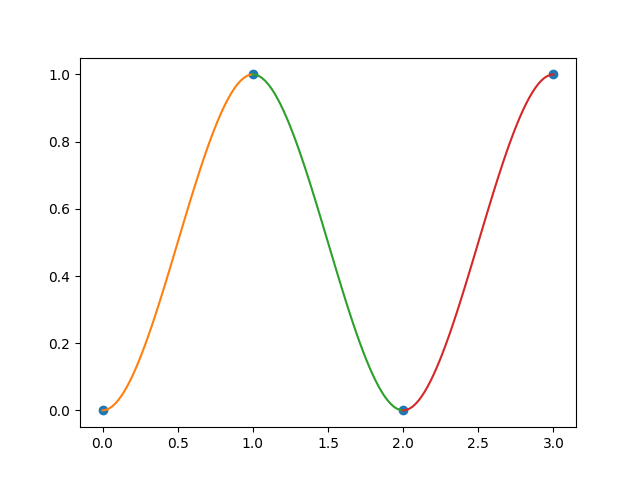

In [18]:
y3 = -2*x**3 + 3*x**2

fig8, (ax12) = plt.subplots(1, 1)

ax12.plot([0,1,2,3], [0,1,0,1], 'o')
ax12.plot(x, y3)
ax12.plot(x+1, 1-y3)
ax12.plot(x+2, y3)

# Hermite Curve

We want to be able to fit several curve back to back. To accomplish this, we would like to specify a
curve by providing:
* endPoints
* first derivative at the endPoints

## polynomial 
But first let's see the math behind a cubic polynomial fit.

* Any polynomial of degree n can pass through n+1 points.

Text(0, 0.5, 'y')

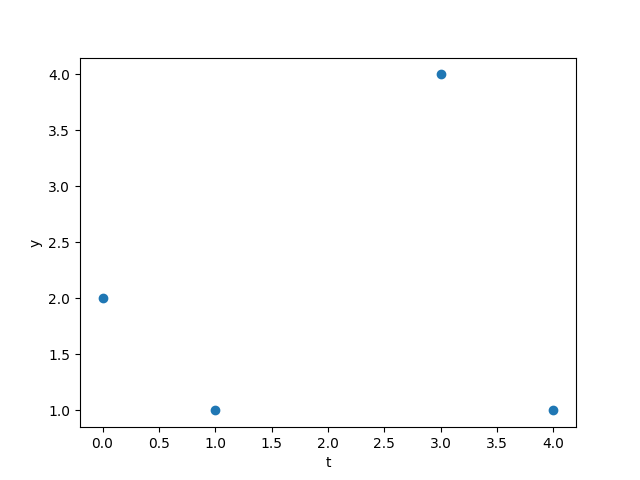

In [19]:
# 4 points
t = np.array([0, 1, 3, 4])
y = np.array([2.0, 1.0, 4.0, 1.0])

fig9, (ax13) = plt.subplots(1, 1)

ax13.plot(t, y, 'o')
ax13.set_xlabel("t")
ax13.set_ylabel("y")

We start from the cubic function
$$
Q(t) = at^3 + bt^2 + ct + d
$$
and set our constraints knowing the values we want to reach for each t's

$$Q(0) = 2$$
$$Q(1) = 1$$
$$Q(3) = 4$$
$$Q(4) = 1$$

which gives us :

$$d = 2$$
$$a + b + c + d = 1$$
$$27a + 9b + 3c + d = 4$$
$$64a + 16b + 4c + d = 1$$

4 equations of 4 unknown, written in matrix form :

$$
\left[\begin{matrix}2 \\ 1 \\ 4 \\ 1 \end{matrix}\right] = 
\left[\begin{matrix}0 & 0 & 0 & 1 \\ 1 & 1 & 1 & 1\\ 27 & 9 & 3 & 1\\ 64 & 16 & 4 & 1 \end{matrix}\right]
\left[\begin{matrix}a\\b\\c\\d\end{matrix}\right]
$$

and we can solve for $\left[\begin{matrix}a\\b\\c\\d\end{matrix}\right]$

In [20]:
M = np.array([
    [0, 0, 0, 1],
    [1, 1, 1, 1],
    [27, 9, 3, 1],
    [64, 16, 4, 1],
])
a,b,c,d = np.linalg.solve(M, y)
a,b,c,d

(-0.5833333333333333, 3.1666666666666665, -3.5833333333333335, 2.0)

Text(0, 0.5, 'y')

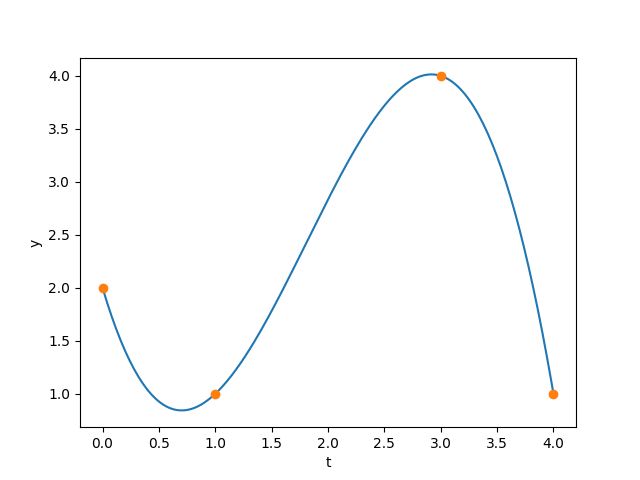

In [21]:
ts = np.linspace(0, 4, 200)
ys = a * ts**3 + b * ts**2 + c * ts + d

fig10, (ax14) = plt.subplots(1, 1)

ax14.plot(ts, ys, '-')
ax14.plot(t, y, 'o')
ax14.set_xlabel("t")
ax14.set_ylabel("y")

## Hermite
So, again we will start from a parametric cubic function.

$$
Q(t) = at^3 + bt^2 + ct + d
$$

and if we write this as matrix from as before we have again
$$
Q(t) = \left[\begin{matrix}t^{3} & t^{2} & t & 1\end{matrix}\right] \left[\begin{matrix}a\\b\\c\\d\end{matrix}\right]
$$

We want to define a curve by using a Point $P(0)$ at time t = 0, a point $P(1)$ at t = 1, a derivative $\frac{d}{dt} P(0)$ at t = 0, and a derivative a $\frac{d}{dt} P(1)$ at t = 1.

We need the first derivative of Q:
$$
\frac{d}{dt}Q(t) = 3at^2 + 2bt + c
$$

We can build a system of equation with the computed values:

$$
\left[\begin{matrix}P(0) \\ P(1) \\ \frac{d}{dt}P(0)\\ \frac{d}{dt}P(1) \end{matrix}\right] = 
\left[\begin{matrix}0 & 0 & 0 & 1 \\ 1 & 1 & 1 & 1\\ 0 & 0 & 1 & 0\\ 3 & 2 & 1 & 0 \end{matrix}\right]
\left[\begin{matrix}a\\b\\c\\d\end{matrix}\right]
$$

We can solve for $\left[\begin{matrix}a\\b\\c\\d\end{matrix}\right]$ by taking the inverse of the 4x4 matrix

$$
\left[\begin{matrix}a\\b\\c\\d\end{matrix}\right] = 
\left[\begin{matrix}0 & 0 & 0 & 1 \\ 1 & 1 & 1 & 1\\ 0 & 0 & 1 & 0\\ 3 & 2 & 1 & 0 \end{matrix}\right]^{-1}
\left[\begin{matrix}P(0) \\ P(1) \\ \frac{d}{dt}P(0)\\ \frac{d}{dt}P(1) \end{matrix}\right]
$$


In [22]:
Hm = sym.Matrix([[0,0,0,1],[1,1,1,1],[0,0,1,0],[3,2,1,0]])
Hm.inv()

Matrix([
[ 2, -2,  1,  1],
[-3,  3, -2, -1],
[ 0,  0,  1,  0],
[ 1,  0,  0,  0]])

$$
\left[\begin{matrix}a\\b\\c\\d\end{matrix}\right] = 
\left[\begin{matrix}2 & -2 & 1 & 1\\-3 & 3 & -2 & -1\\0 & 0 & 1 & 0\\1 & 0 & 0 & 0\end{matrix}\right]
\left[\begin{matrix}P(0) \\ P(1) \\ \frac{d}{dt}P(0)\\ \frac{d}{dt}P(1) \end{matrix}\right]
$$

We can now substitude the $[a, b, c, d]$ in the $Q(t)$ formula.

$$
Q(t) = \left[\begin{matrix}t^{3} & t^{2} & t & 1\end{matrix}\right]
\left[\begin{matrix}2 & -2 & 1 & 1\\-3 & 3 & -2 & -1\\0 & 0 & 1 & 0\\1 & 0 & 0 & 0\end{matrix}\right]
\left[\begin{matrix}P(0) \\ P(1) \\ \frac{d}{dt}P(0)\\ \frac{d}{dt}P(1) \end{matrix}\right]
$$

In [23]:
P0, P1, dP0, dP1 = sym.symbols('P0 P1 dP0 dP1')
C = sym.Matrix([P0, P1, dP0, dP1])

Q = vT*Hm.inv()*C
Q

Matrix([[P0*(2*t**3 - 3*t**2 + 1) + P1*(-2*t**3 + 3*t**2) + dP0*(t**3 - 2*t**2 + t) + dP1*(t**3 - t**2)]])

### 1d example

Text(0, 0.5, 'y')

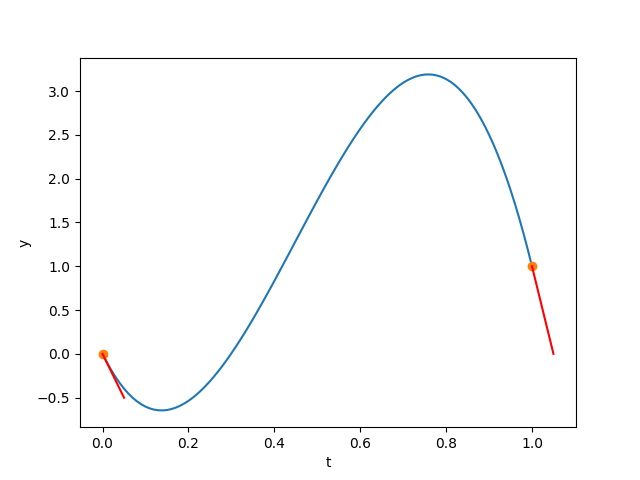

In [24]:
Pt = np.array([0, 1, -10, -20.0])
ts = np.linspace(0, 1, 101)

# use the formula 
ys = Pt[0] * (2*ts**3 - 3*ts**2 + 1) + Pt[1] * (-2*ts**3 + 3*ts**2) + Pt[2] * (ts**3 - 2*ts**2 + ts) + Pt[3] * (ts**3 - ts**2)


fig11, (ax15) = plt.subplots(1, 1)

ax15.plot(ts, ys, '-')
ax15.plot([0, 1], Pt[:2], 'o')
ax15.plot([0, 0.05], [Pt[0], Pt[0] + 0.05 * Pt[2]], '-', color='red')
ax15.plot([1, 1.05], [Pt[1], Pt[1] + 0.05 * Pt[3]], '-', color='red')
ax15.set_xlabel("t")
ax15.set_ylabel("y")

### 2d example

Text(0, 0.5, 'y')

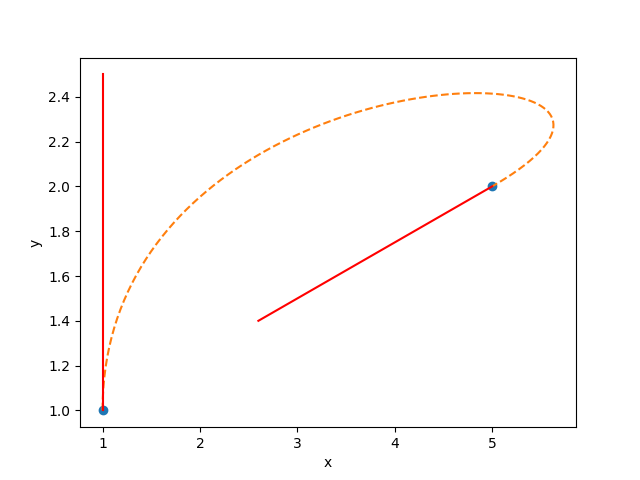

In [25]:
Pt = np.array(
    [[1,1], 
     [5,2], 
     [0, 5], 
     [-8, -2]
    ])
ts = np.linspace(0, 1, 101)

# use the matrix math :
Hm = np.array([[2, -2, 1, 1],[-3, 3, -2, -1],[0, 0, 1, 0],[1, 0, 0, 0]], dtype=np.double)
Pts = np.dot(Hm, Pt)
Pts = np.dot(np.column_stack([ts**3, ts**2, ts, np.ones_like(ts)]), Pts)

fig12, (ax16) = plt.subplots(1, 1)

ax16.plot(Pt[:2, 0], Pt[:2, 1], 'o')
ax16.plot(Pts[:, 0], Pts[:, 1], '--')
ax16.plot([Pt[0, 0], Pt[0,0] + Pt[2,0]*.3], [Pt[0, 1], Pt[0,1] + Pt[2,1]*.3], '-', color='red')
ax16.plot([Pt[1, 0], Pt[1,0] + Pt[3,0]*.3], [Pt[1, 1], Pt[1,1] + Pt[3,1]*.3], '-', color='red')
ax16.set_xlabel("x")
ax16.set_ylabel("y")

### Links between Hermite and Bezier

We can convert from Hermite to Bezier by computing the 2 extra points from the tangent.
$$
\begin{align}
Pt(0) &= Pt(0) \\
Pt(1) &= Pt(0) + \frac{d}{dt}Pt(0) / 3 \\
Pt(2) &= Pt(1) - \frac{d}{dt}Pt(1) / 3 \\
Pt(4) &= Pt(1)
\end{align}
$$

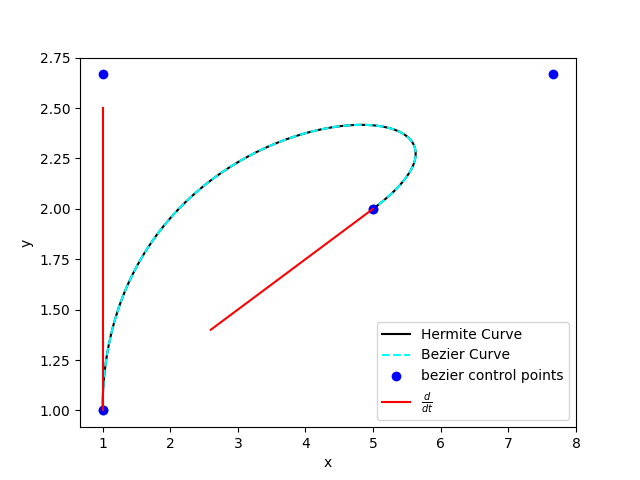

In [26]:
BPt = np.array([
    Pt[0],
    Pt[0] + Pt[2] / 3.0,
    Pt[1] - Pt[3] / 3.0,
    Pt[1]
])

BPts = bezier(BPt, ts)

fig13, (ax17) = plt.subplots(1, 1)

ax17.plot(Pt[:2, 0], Pt[:2, 1], 'o')
ax17.plot(Pts[:, 0], Pts[:, 1], '-', label='Hermite Curve', color='black')
ax17.plot(BPts[:, 0], BPts[:, 1], '--', label='Bezier Curve', color='cyan')

ax17.plot(BPt[:, 0], BPt[:, 1], 'o', color='blue', label='bezier control points')
ax17.plot([Pt[0, 0], Pt[0,0] + Pt[2,0]*.3], [Pt[0, 1], Pt[0,1] + Pt[2,1]*.3], '-', color='red', label='$\\frac{d}{dt}$')
ax17.plot([Pt[1, 0], Pt[1,0] + Pt[3,0]*.3], [Pt[1, 1], Pt[1,1] + Pt[3,1]*.3], '-', color='red')
ax17.set_xlabel("x")
ax17.set_ylabel("y")
ax17.legend()

## Hermite Spline

We can concatenate different Hermite curve again.  
To make it simpler to iterate we will encode $Pt(i), \frac{d}{dt}Pt(i), Pt(i+1), \frac{d}{dt}Pt(i+1) ...$ in the array

In [27]:
def hermite(Pt, t):
    #Pt, d/dt, Pt, d/dt  --> column are swapped
    Hm = np.array([[2, 1, -2, 1],[-3, -2, 3, -1],[0, 1, 0, 0],[1, 0, 0, 0]], dtype=np.double)
    Pt = np.dot(Hm, Pt)
    return np.dot(np.column_stack([t**3, t**2, t, np.ones_like(t)]), Pt)

def hermite_spline(P, t):
    segment = int((P.shape[0]/2)-1)
    output = np.zeros([t.shape[0], P.shape[1]])
    index = 0
    for s in range(segment):
        where = np.logical_and(t >= s, t <= s+1)
        output[where, :] = hermite(P[index:index+4, ...], t[where] - s)
        index += 2
    return output

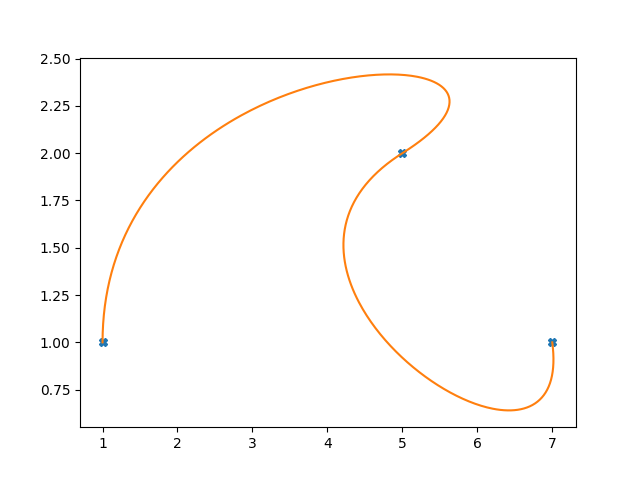

In [28]:
HPts = np.array([
    [1,1], [0, 5], 
    [5,2], [-8, -2],
    [7,1], [-1, 3]
])

her = hermite_spline(HPts, np.linspace(0,2, 400))

fig14, (ax18) = plt.subplots(1, 1)

ax18.plot(HPts[[0,2,4],0], HPts[[0,2,4],1], 'X')
ax18.plot(her[:, 0], her[:, 1])


# Cardinal Spline

Cardinal Spline is in interpolation spline that goes through all the points. It uses Hermite curves and compute automatically the tangents.  
In a lists of Points $P_1, P_{i+1} ..., P_n$ the tangent of the Hermite curves are computed as 
$$\frac{d}{dt}P_i = s(P_{i+1} - P_{i-1})$$

In [29]:
def cardinal_to_hermite_with_s(Pts, s):
    hermites = np.zeros([Pts.shape[0] * 2 - 4, Pts.shape[1]])
    hermites[::2, :] = Pts[1:-1]
    hermites[1::2, :] = s * (Pts[2:, :] - Pts[:-2, :])
    return hermites

interactive(children=(FloatSlider(value=1.0, description='s', max=3.0), Output()), _dom_classes=('widget-inter…

<function __main__.draw_hermite_spline_s(s)>

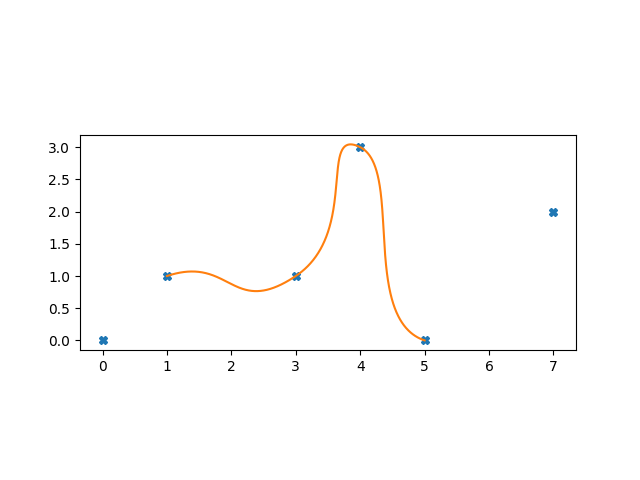

In [31]:
Pts = np.array([
    [0, 0],
    [1, 1],
    [3, 1],
    [4, 3],
    [5, 0],
    [7, 2]
])

fig19, (ax20) = plt.subplots(1, 1)
ax20.set_aspect('equal')

def draw_hermite_spline_s(s):
    hemite_pts = cardinal_to_hermite_with_s(Pts, s)
    her = hermite_spline(hemite_pts, np.linspace(0, hemite_pts.shape[0]/2-1, 1000))

    ax20.cla()

    ax20.plot(Pts[:,0], Pts[:,1], 'X')
    ax20.plot(her[:, 0], her[:, 1])

interact(
    draw_hermite_spline_s, 
    s= widgets.FloatSlider(value = 1, min=0, max=3)
)

## Tension parameter

The S parameter is not intuitive, we usually works with 'tension'. Larger tension should ‘pull’ the curve closer to a straight-line interpolation of the knots, with exactly straight lines as a limiting case.  
So Tension is usually implemented as
$$
s = \frac{(1 - T)}{2} 
$$
With $T$ in the closed interval $[0, 1]$.

So a $T = 0$ will return a $s = \frac{1}{2}$ which is a <b>Catmul-Rom Spline</b>.

In [32]:
def cardinal_to_hermite(Pts, tension):
    s = (1.0 - tension)*0.5
    hermites = np.zeros([Pts.shape[0] * 2 - 4, Pts.shape[1]])
    hermites[::2, :] = Pts[1:-1]
    hermites[1::2, :] = s * (Pts[2:, :] - Pts[:-2, :])
    return hermites

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0), Output()), _dom_classes=('widget-inter…

<function __main__.draw_hermite_spline_t(t)>

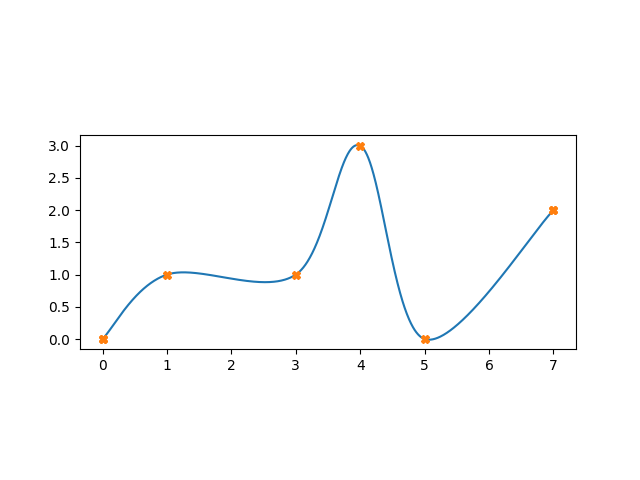

In [33]:
# repeat first and last to get a tangent at those points
Pts = np.array([
    [0, 0],
    [0, 0],
    [1, 1],
    [3, 1],
    [4, 3],
    [5, 0],
    [7, 2],
    [7, 2]
])

fig20, (ax21) = plt.subplots(1, 1)
ax21.set_aspect('equal')

def draw_hermite_spline_t(t):
    hemite_pts = cardinal_to_hermite(Pts, t)
    her = hermite_spline(hemite_pts, np.linspace(0, hemite_pts.shape[0]/2-1, 1000))

    ax21.cla()

    ax21.plot(her[:, 0], her[:, 1])
    ax21.plot(Pts[:,0], Pts[:,1], 'X')
    

interact(
    draw_hermite_spline_t, 
    t= widgets.FloatSlider(value = 0, min=0, max=1)
)

## Cardinal Spline Base Matrix

We can also convert the cardinal curve into a matrix form, by starting from the Hermite definition.

In [34]:
Hm = sym.Matrix([[0,0,0,1],[1,1,1,1],[0,0,1,0],[3,2,1,0]])
P0, P1, P2, P3, s, dP1, dP2 = sym.symbols('P0 P1 P2 P3 s dP1 dP2')
C = sym.Matrix([P1, P2, dP1, dP2])

display('Hermite curve :')
Q = (vT*Hm.inv()*C)[0]
display(Q)

display('Replace d/dt by the Slope computation :')
Q = Q.subs({dP1 : s*(P2 - P0), dP2: s*(P3 - P1)})
display(Q)

display('factorize :')
display(sym.collect(sym.factor(Q.expand()), (P0, P1, P2, P3)))

'Hermite curve :'

P1*(2*t**3 - 3*t**2 + 1) + P2*(-2*t**3 + 3*t**2) + dP1*(t**3 - 2*t**2 + t) + dP2*(t**3 - t**2)

'Replace d/dt by the Slope computation :'

P1*(2*t**3 - 3*t**2 + 1) + P2*(-2*t**3 + 3*t**2) + s*(-P0 + P2)*(t**3 - 2*t**2 + t) + s*(-P1 + P3)*(t**3 - t**2)

'factorize :'

P0*(-s*t**3 + 2*s*t**2 - s*t) + P1*(-s*t**3 + s*t**2 + 2*t**3 - 3*t**2 + 1) + P2*(s*t**3 - 2*s*t**2 + s*t - 2*t**3 + 3*t**2) + P3*(s*t**3 - s*t**2)

Formulated as a Matrix :

$$
Q(t) = \left[\begin{matrix}t^{3} & t^{2} & t & 1\end{matrix}\right]
\left[\begin{matrix}-s & 2s & -s & 0\\2-s & s-3 & 0 & 1\\s-2 & 3-2s & s & 0\\s & -s & 0 & 0\end{matrix}\right]^T
\left[\begin{matrix}P_0 \\ P_1 \\ P_2\\ P_3 \end{matrix}\right]
$$

In [35]:
def cardinal_curve(Pt, t, tension):
    s = (1.0 - tension)*0.5
    CCM = np.array([[-s, 2*s, -s, 0],[2-s, s-3 , 0, 1],[s-2 ,3-2*s, s, 0], [s, -s, 0, 0]], dtype=np.double)
    Pt = np.dot(CCM.T, Pt)
    return np.dot(np.column_stack([t**3, t**2, t, np.ones_like(t)]), Pt)

def cardinal_spline(P, t, tension):
    segment = int(P.shape[0]-2)
    output = np.zeros([t.shape[0], P.shape[1]])
    index = 0
    for s in range(segment-1):
        where = np.logical_and(t >= s, t <= s+1)
        output[where, :] = cardinal_curve(P[index:index+4, ...], t[where] - s, tension)
        index += 1
        
    return output

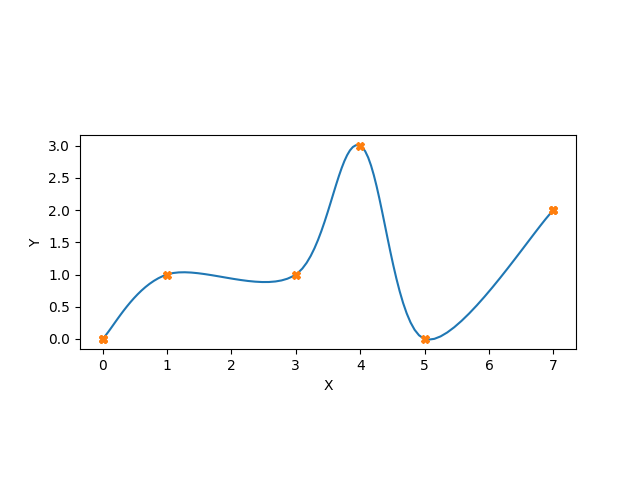

In [36]:

fig20b, (ax21b) = plt.subplots(1, 1)


cardinal_pt = cardinal_spline(Pts, np.linspace(0, Pts.shape[0]-3, 100), 0)

ax21b.plot(cardinal_pt[:,0], cardinal_pt[:,1], '-')
ax21b.plot(Pts[:,0], Pts[:,1], 'X')

ax21b.set_xlabel("X")
ax21b.set_ylabel("Y")
ax21b.set_aspect('equal')

Cardinal Spline have at best a C1 continuity.

interactive(children=(FloatSlider(value=1.0, description='t', max=1.0), Output()), _dom_classes=('widget-inter…

<function __main__.cardinal_continuity(t)>

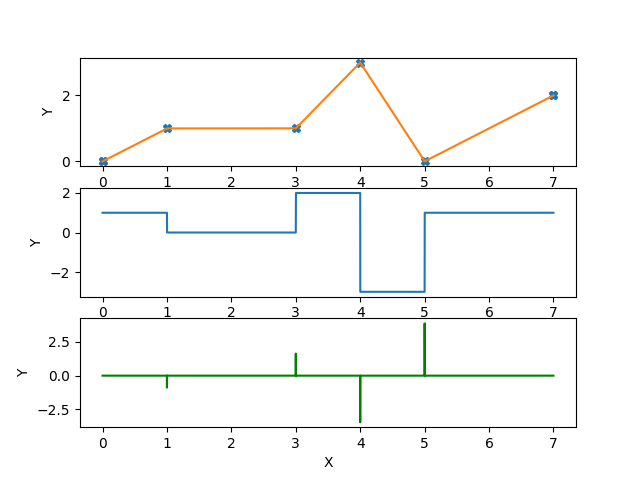

In [37]:
fig20c, (ax20c, bx20c, cx20c) = plt.subplots(3, 1)

def cardinal_continuity(t):
    ax20c.cla()
    bx20c.cla()
    cx20c.cla()
    
    cardinal_pt = cardinal_spline(Pts, np.linspace(0, Pts.shape[0]-3, 1000), t)

    ax20c.plot(Pts[:,0], Pts[:,1], 'X')
    ax20c.plot(cardinal_pt[:,0], cardinal_pt[:,1], '-')

    ax20c.set_xlabel("X")
    ax20c.set_ylabel("Y")

    derivatives_x =  (cardinal_pt[1:,0] + cardinal_pt[:-1,0]) / 2
    derivatives_y =  (cardinal_pt[1:,1] - cardinal_pt[:-1,1]) / (cardinal_pt[1:,0] - cardinal_pt[:-1,0])

    bx20c.plot(derivatives_x, derivatives_y, '-')
    bx20c.set_xlabel("X")
    bx20c.set_ylabel("Y")

    derivative2_x =  (derivatives_x[1:] + derivatives_x[:-1]) / 2
    derivative2_y = derivatives_y[1:] - derivatives_y[:-1]

    cx20c.plot(derivative2_x, derivative2_y, '-g')
    cx20c.set_xlabel("X")
    cx20c.set_ylabel("Y")

interact(
    cardinal_continuity, 
    t= widgets.FloatSlider(value = 1, min=0, max=1)
)

# Uniform Cubic B-Spline
to get a C2 continuity

## De Boor algorithm


interactive(children=(IntSlider(value=0, description='frame', max=5), Output()), _dom_classes=('widget-interac…

<function __main__.animate_uniform_cubic(frame)>

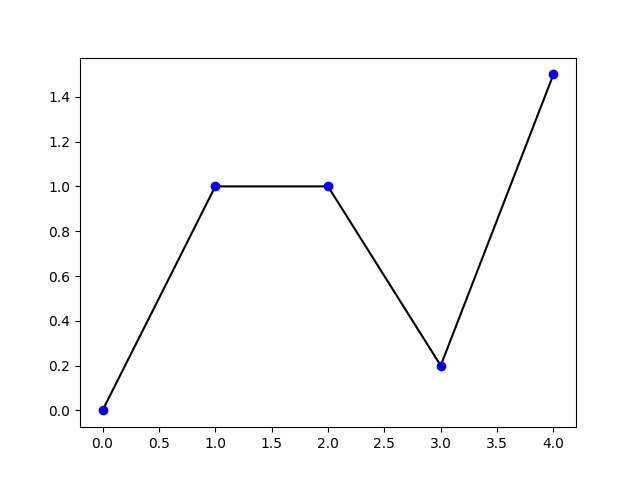

In [38]:
Pts = np.array([
    [0, 0],
    [1, 1],
    [2, 1],
    [3, 0.2],
    [4, 1.5],
])

fig21, (ax22) = plt.subplots(1, 1)

def animate_uniform_cubic(frame):
    ax22.cla()
    
    ax22.plot(Pts[:,0], Pts[:,1], '-', color='black')
    ax22.plot(Pts[:,0], Pts[:,1], 'o', color='blue')
    
    if(frame > 0):
        interA =Pts[:-1] + (Pts[1:] - Pts[:-1])/3.0
        interB =Pts[:-1] + (Pts[1:] - Pts[:-1])/3.0*2.0
        ax22.plot(interA[:,0], interA[:,1], 'o', color='gray')
        ax22.plot(interB[:,0], interB[:,1], 'o', color='gray')
    
    if(frame > 1):
        ax22.plot((interA[1:,0], interB[:-1,0]), (interA[1:,1], interB[:-1,1]), '-', color='gray')
    
    if(frame > 2):
        mids = interB[:-1] + (interA[1:] - interB[:-1]) * 0.5
        ax22.plot(mids[:,0], mids[:,1], 'o', color='black')
    
    if(frame > 3):
        bPts = np.array([mids[0], interA[1], interB[1], mids[1]])
        ax22.plot(bPts[:,0], bPts[:,1], 'o', color='green')
        bez = bezier(bPts,np.linspace(0,1,100))
        ax22.plot(bez[:,0], bez[:,1] , '-', color='red')
    
    if(frame > 4):
        bPts = np.array([mids[1], interA[2], interB[2], mids[2]])
        ax22.plot(bPts[:,0], bPts[:,1], 'o', color='green')
        bez = bezier(bPts,np.linspace(0,1,100))
        ax22.plot(bez[:,0], bez[:,1] , '-', color='red')
    
interact(
    animate_uniform_cubic, 
    frame= widgets.IntSlider(value = 0, min=0, max=5)
)

C2 continuity

Text(0, 0.5, 'Y')

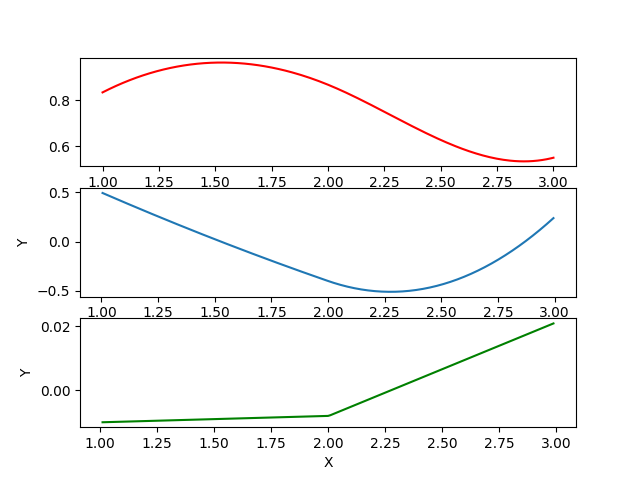

In [39]:
interA =Pts[:-1] + (Pts[1:] - Pts[:-1])/3.0
interB =Pts[:-1] + (Pts[1:] - Pts[:-1])/3.0*2.0
mids = interB[:-1] + (interA[1:] - interB[:-1]) * 0.5


bez = np.zeros([200,2])
bPts = np.array([mids[0], interA[1], interB[1], mids[1]])
bez[:101] = bezier(bPts,np.linspace(0,1,101))
bPts = np.array([mids[1], interA[2], interB[2], mids[2]])
bez[100:] = bezier(bPts,np.linspace(0,1,100))

fig21c, (ax21c, bx21c, cx21c) = plt.subplots(3, 1)

ax21c.plot(bez[:,0], bez[:,1] , '-', color='red')

derivatives_x =  (bez[1:,0] + bez[:-1,0]) / 2
derivatives_y =  (bez[1:,1] - bez[:-1,1]) / (bez[1:,0] - bez[:-1,0])

bx21c.plot(derivatives_x, derivatives_y, '-')
bx21c.set_xlabel("X")
bx21c.set_ylabel("Y")

derivative2_x =  (derivatives_x[1:] + derivatives_x[:-1]) / 2
derivative2_y = derivatives_y[1:] - derivatives_y[:-1]

cx21c.plot(derivative2_x, derivative2_y, '-g')
cx21c.set_xlabel("X")
cx21c.set_ylabel("Y")

## Cox - De Boor Basis

For a B-spline of degree $k$ with a knot vector $\mathbf{T} = [t_0, t_1, t_2, \ldots, t_{n+k+1}]$ and basis functions $\{b_i^k(t)\}$, the Cox-De Boor recursive definition is as follows:

$$
\begin{align}
b_i^0(t) &=
\begin{cases}
1, & \text{if } t_i \leq t < t_{i+1} \\
0, & \text{otherwise}
\end{cases} \\
b_i^k(t) &= \frac{t - t_i}{t_{i+k} - t_i}b_i^{k-1}(t) + \frac{t_{i+k+1} - t}{t_{i+k+1} - t_{i+1}}b_{i+1}^{k-1}(t)
\end{align}
$$

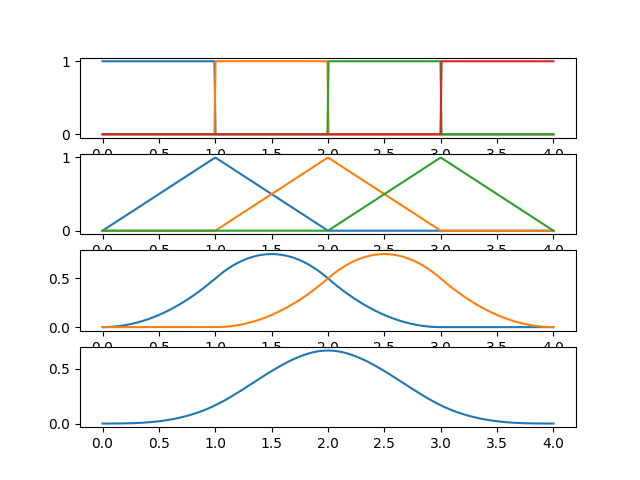

In [40]:
Ts = np.linspace(0,4,400)

b_0_0 = np.zeros([400])
b_0_0[np.logical_and(Ts >= 0, Ts < 1)] = 1.0

b_0_1 = np.zeros([400])
b_0_1[np.logical_and(Ts >= 1, Ts < 2)] = 1.0

b_0_2 = np.zeros([400])
b_0_2[np.logical_and(Ts >= 2, Ts < 3)] = 1.0

b_0_3 = np.zeros([400])
b_0_3[Ts >= 3] = 1.0

fig22, (ax23, ax24, ax25, ax26) = plt.subplots(4, 1)

ax23.plot(Ts, b_0_0)
ax23.plot(Ts, b_0_1)
ax23.plot(Ts, b_0_2)
ax23.plot(Ts, b_0_3)

b_1_0 = (Ts - 0)/(1 - 0)*b_0_0 + (2 - Ts)/(2 - 1)*b_0_1
b_1_1 = (Ts - 1)/(2 - 1)*b_0_1 + (3 - Ts)/(3 - 2)*b_0_2
b_1_2 = (Ts - 2)/(3 - 2)*b_0_2 + (4 - Ts)/(4 - 3)*b_0_3

ax24.plot(Ts, b_1_0)
ax24.plot(Ts, b_1_1)
ax24.plot(Ts, b_1_2)

b_2_0 = (Ts - 0)/(2 - 0)*b_1_0 + (3 - Ts)/(3 - 1)*b_1_1
b_2_1 = (Ts - 1)/(3 - 1)*b_1_1 + (4 - Ts)/(4 - 2)*b_1_2

ax25.plot(Ts, b_2_0)
ax25.plot(Ts, b_2_1)

b_3_0 = (Ts - 0)/(3 - 0)*b_2_0 + (4 - Ts)/(4 - 1)*b_2_1

ax26.plot(Ts, b_3_0)

In [41]:
b_3_0, b_3_1, b_2_0, b_2_1, b_2_2, b_1_0, b_1_1, b_1_2, b_1_3, b_0_0, b_0_1, b_0_2, b_0_3, b_0_4, t = sym.symbols("b_3_0 b_3_1 b_2_0 b_2_1 b_2_2 b_1_0 b_1_1 b_1_2 b_1_3 b_0_0 b_0_1 b_0_2 b_0_3 b_0_4 t")

b_1_0 = (t -0)*b_0_0 + (2-t)*b_0_1
b_1_1 = (t -1)*b_0_1 + (3-t)*b_0_2
b_1_2 = (t -2)*b_0_2 + (4-t)*b_0_3

b_2_0 = (t -0)/2*b_1_0 + (3-t)/2*b_1_1
b_2_1 = (t -1)/2*b_1_1 + (4-t)/2*b_1_2

b_3_0 = (t -0)/3*b_2_0 + (4-t)/3*b_2_1

formula = sym.collect(sym.together(sym.expand(b_3_0)), [b_0_0, b_0_1, b_0_2, b_0_3])

display(formula)


b_0_0*t**3/6 + b_0_1*(-3*t**3 + 12*t**2 - 12*t + 4)/6 + b_0_2*(3*t**3 - 24*t**2 + 60*t - 44)/6 + b_0_3*(-t**3 + 12*t**2 - 48*t + 64)/6

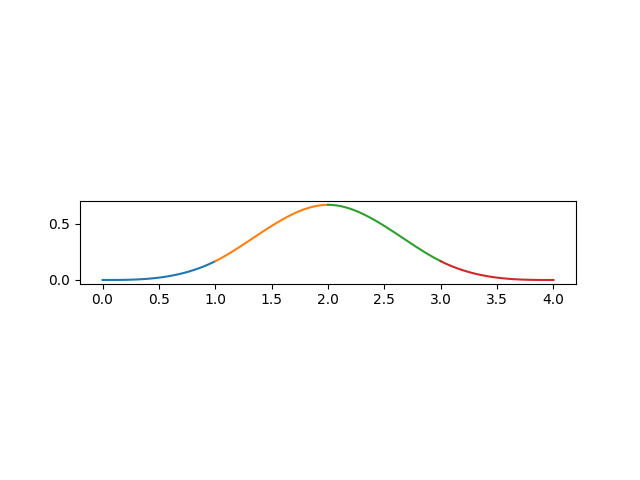

In [42]:
def fb_0(ts):
    return ts**3 / 6.0
    
def fb_1(ts):
    return (-3*ts**3 + 12*ts**2 - 12*ts +4)/6.0

def fb_2(ts):
    return (3*ts**3 - 24*ts**2 + 60*ts -44)/6.0

def fb_3(ts):
    return (-ts**3 + 12*ts**2 - 48*ts +64)/6.0

fig23, (ax27) = plt.subplots(1, 1)

ax27.plot(np.linspace(0,1,100), fb_0(np.linspace(0,1,100)))
ax27.plot(np.linspace(1,2,100), fb_1(np.linspace(1,2,100)))
ax27.plot(np.linspace(2,3,100), fb_2(np.linspace(2,3,100)))
ax27.plot(np.linspace(3,4,100), fb_3(np.linspace(3,4,100)))
ax27.set_aspect('equal')

Shift all the pieces to be between 0 and 1

In [43]:
display(sym.together(sym.expand(formula.subs({b_0_0:1, b_0_1:0, b_0_2:0, b_0_3:0}).subs({t:t}))))
display(sym.together(sym.expand(formula.subs({b_0_0:0, b_0_1:1, b_0_2:0, b_0_3:0}).subs({t:t+1}))))
display(sym.together(sym.expand(formula.subs({b_0_0:0, b_0_1:0, b_0_2:1, b_0_3:0}).subs({t:t+2}))))
display(sym.together(sym.expand(formula.subs({b_0_0:0, b_0_1:0, b_0_2:0, b_0_3:1}).subs({t:t+3}))))

t**3/6

(-3*t**3 + 3*t**2 + 3*t + 1)/6

(3*t**3 - 6*t**2 + 4)/6

(-t**3 + 3*t**2 - 3*t + 1)/6

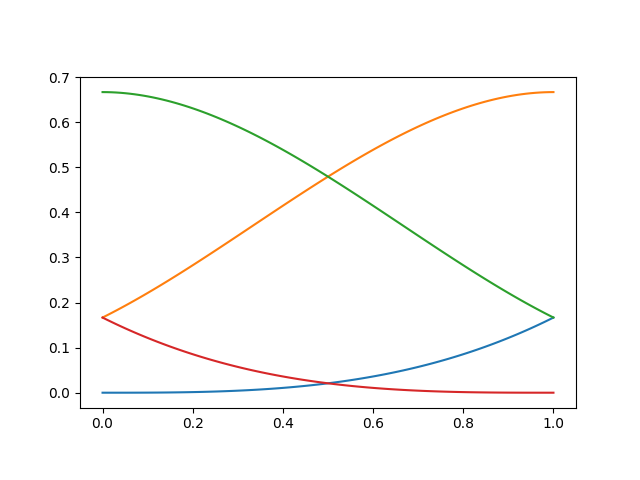

In [44]:
def fb_0(ts):
    return ts**3 / 6.0
    
def fb_1(ts):
    return (-3*ts**3 + 3*ts**2 + 3*ts +1)/6.0

def fb_2(ts):
    return (3*ts**3 - 6*ts**2 + 4)/6.0

def fb_3(ts):
    return (-ts**3 + 3*ts**2 - 3*ts +1)/6.0

fig24, (ax28) = plt.subplots(1, 1)

ax28.plot(np.linspace(0,1,100), fb_0(np.linspace(0,1,100)))
ax28.plot(np.linspace(0,1,100), fb_1(np.linspace(0,1,100)))
ax28.plot(np.linspace(0,1,100), fb_2(np.linspace(0,1,100)))
ax28.plot(np.linspace(0,1,100), fb_3(np.linspace(0,1,100)))
ax28.set_aspect('equal')

Matrix form :

The last function is the one that is shifted to the left the most, so it must be applied to the point the most of the left $\rightarrow P_0$.

$$
Q(t) = P_0(\frac{- t^{3} + 3 t^{2} - 3 t + 1}{6}) + P_1(\frac{3 t^{3} - 6 t^{2} + 4}{6}) + P_2(\frac{- 3 t^{3} + 3 t^{2} + 3 t + 1}{6}) + P_3(\frac{t^{3}}{6})
$$

Which can be written as :

$$
Q(t) = \left[\begin{matrix}t^{3} & t^{2} & t & 1\end{matrix}\right]
\frac{1}{6}\left[\begin{matrix}-1 & 3 & -3 & 1\\3 & -6 & 3 & 0\\-3 & 0 & 3 & 0\\1 & 4 & 1 & 0\end{matrix}\right]
\left[\begin{matrix}P_0 \\ P_1 \\ P_2 \\ P_3 \end{matrix}\right]
$$

In [45]:
def bspline_segment(Pt, t):
    BS = np.array([[-1,3,-3,1],[3,-6,0,4],[-3,3,3,1], [1,0,0,0]], dtype=np.double)/6.0
    Pt = np.dot(BS.T, Pt)
    return np.dot(np.column_stack([t**3, t**2, t, np.ones_like(t)]), Pt)

def bspline(P, t):
    segment = int(P.shape[0]-3)
    output = np.zeros([t.shape[0], P.shape[1]])
    index = 0
    for s in range(segment):
        where = np.logical_and(t >= s, t <= s+1)
        output[where, :] = bspline_segment(P[index:index+4, ...], t[where] - s)
        index += 1
    return output

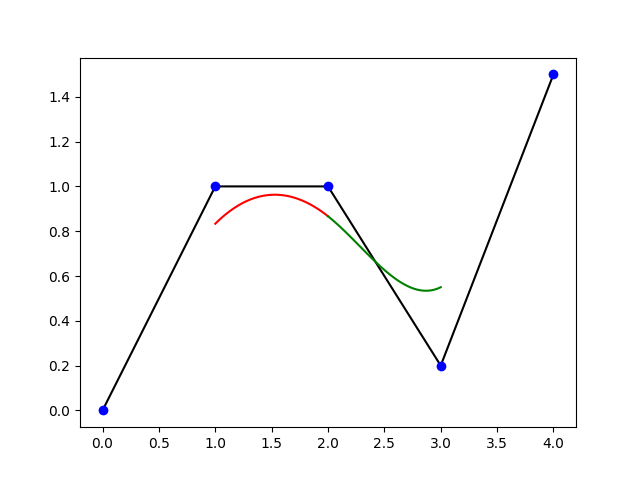

In [46]:
Pts = np.array([
    [0, 0],
    [1, 1],
    [2, 1],
    [3, 0.2],
    [4, 1.5],
])

fig25, (ax29) = plt.subplots(1, 1)


ax29.cla()

ax29.plot(Pts[:,0], Pts[:,1], '-', color='black')
ax29.plot(Pts[:,0], Pts[:,1], 'o', color='blue')

bsp = bspline_segment(Pts[:4,:], np.linspace(0,1,100))
ax29.plot(bsp[:,0], bsp[:,1], '-', color='red')
bsp = bspline_segment(Pts[1:5,:], np.linspace(0,1,100))
ax29.plot(bsp[:,0], bsp[:,1], '-', color='green')

Repeat a point 3 times to pin the curve to that point.

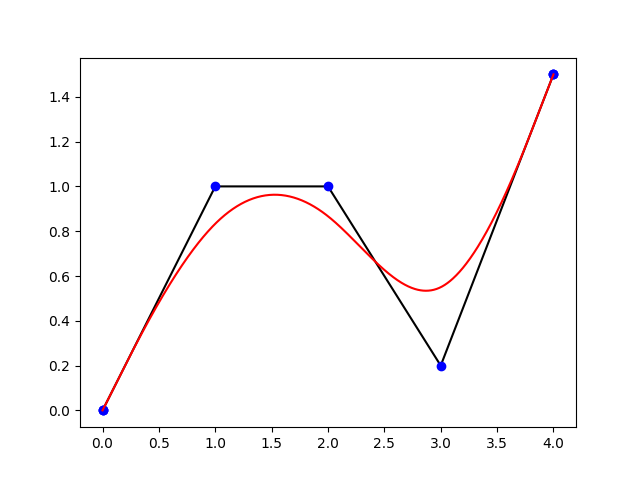

In [47]:
Pts = np.array([
    [0, 0],
    [0, 0],
    [0, 0],
    [1, 1],
    [2, 1],
    [3, 0.2],
    [4, 1.5],
    [4, 1.5],
    [4, 1.5],
])

fig26, (ax30) = plt.subplots(1, 1)


ax30.cla()

ax30.plot(Pts[:,0], Pts[:,1], '-', color='black')
ax30.plot(Pts[:,0], Pts[:,1], 'o', color='blue')

bsp = bspline(Pts, np.linspace(0,Pts.shape[0]-3,1000))
ax30.plot(bsp[:,0], bsp[:,1], '-', color='red')


# One Dimensional Splines

So far most of our example where with 2d points, let's see how we can use the splines with 1d as in a timeline.

## Hermite Curve

To compute an hermite curve in 1 dimension we will bring back the range on x between 0 and 1.  
To do this we need to correct the tangents as they get stretch also.

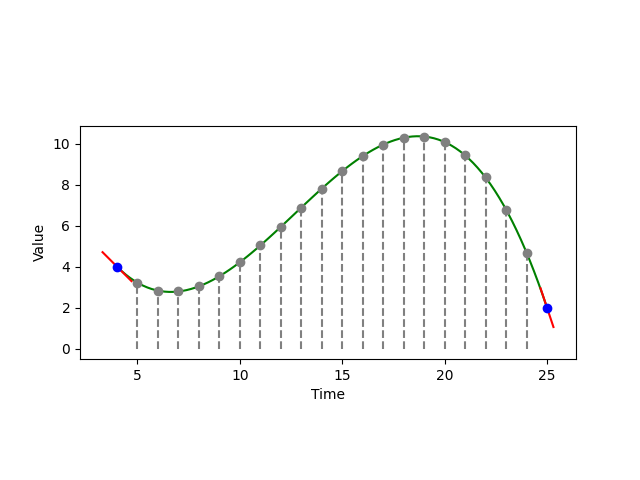

In [48]:
keytimes = np.array([4, 25])
keyvalues = np.array([4,2])
keytangents = np.array([-1, -3])

fig27, (ax31) = plt.subplots(1, 1)

# compute the normalized values for the curve
t_range = keytimes[1] - keytimes[0]
pt = np.array([keyvalues[0], keytangents[0]*t_range, keyvalues[1], keytangents[1]*t_range])

curve = hermite(pt, np.linspace(0,1,100))
ax31.plot(np.linspace(keytimes[0],keytimes[1],100), curve, 'g-')

# show the tangents
def plot_tangent(ax, tangent, x, y):
    dx = 1
    norm = np.sqrt(dx**2 + tangent**2)
    x = (x-dx/norm, x+dx/norm)
    y = (y-tangent/norm, y+tangent/norm)
    ax.plot(x, y, 'r-')
    
plot_tangent(ax31, keytangents[0], keytimes[0], keyvalues[0])
plot_tangent(ax31, keytangents[1], keytimes[1], keyvalues[1])

ax31.plot(keytimes, keyvalues, 'o', color='blue')

# compute key frames
frames = np.linspace(keytimes[0],keytimes[1], t_range+1)
curve_points = hermite(pt, np.linspace(0, 1, t_range+1))

for i in range(1,t_range):
    ax31.plot(frames[i], curve_points[i], 'o', color='gray')
    ax31.plot((frames[i], frames[i]), (0,curve_points[i]), '--', color='gray')

ax31.set_xlabel("Time")
ax31.set_ylabel("Value")
ax31.set_aspect('equal')

## Cardinal Spline

### uniform cardinal spline


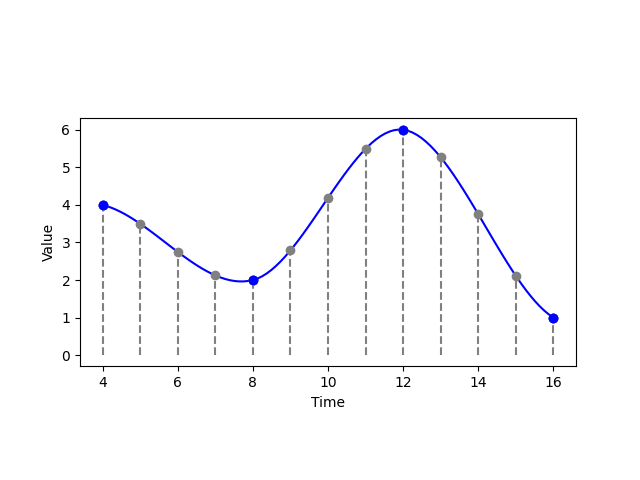

In [49]:
# uniform cardinal spline
keytimes = np.array([4, 8, 12, 16])
keyvalues = np.array([4, 4, 2, 6, 1, 1])


fig29, (ax33) = plt.subplots(1, 1)
cardinal_values = cardinal_spline(keyvalues[:,np.newaxis], np.linspace(0, keyvalues.shape[0]-3, 100), 0) ## <-- tension has no meaning

ax33.plot(np.linspace(keytimes[0], keytimes[-1], 100), cardinal_values, '-', color='blue')
ax33.plot(keytimes, keyvalues[1:-1], 'o', color='blue')

# compute key frames
frames = np.linspace(keytimes[0], keytimes[-1], keytimes[-1]-keytimes[0]+1)
cardinal_values = cardinal_spline(keyvalues[:,np.newaxis], np.linspace(0, keyvalues.shape[0]-3, keytimes[-1]-keytimes[0]+1), 0)[:,0]

for i in range(frames.shape[0]):
    ax33.plot(frames[i], cardinal_values[i], 'o', color='gray')
    ax33.plot((frames[i], frames[i]), (0, cardinal_values[i]), '--', color='gray')
    
ax33.plot(keytimes, keyvalues[1:-1], 'o', color='blue')

ax33.set_xlabel("Time")
ax33.set_ylabel("Value")
ax33.set_aspect('equal')

### non uniform cardinal spline

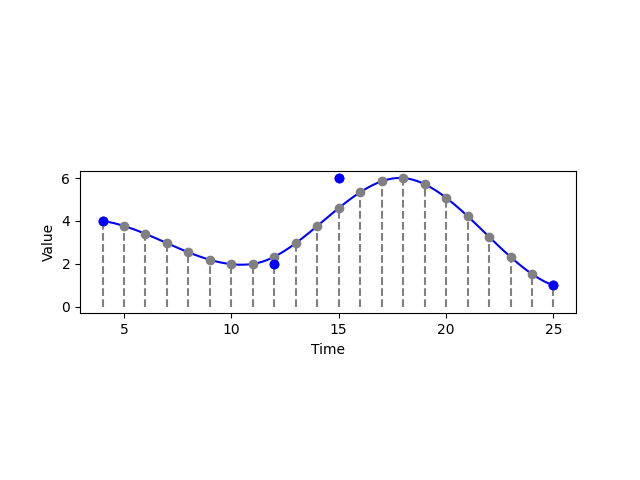

In [50]:
# non uniform cardinal spline -> wrong
keytimes = np.array([4, 12, 15, 25])
keyvalues = np.array([4, 4, 2, 6, 1, 1])


fig30, (ax34) = plt.subplots(1, 1)
cardinal_values = cardinal_spline(keyvalues[:,np.newaxis], np.linspace(0, keyvalues.shape[0]-3, 100), 0) ## <-- again, tension has no meaning

ax34.plot(np.linspace(keytimes[0], keytimes[-1], 100), cardinal_values, '-', color='blue')
ax34.plot(keytimes, keyvalues[1:-1], 'o', color='blue')

# compute key frames
frames = np.linspace(keytimes[0], keytimes[-1], keytimes[-1]-keytimes[0]+1)
cardinal_values = cardinal_spline(keyvalues[:,np.newaxis], np.linspace(0, keyvalues.shape[0]-3, keytimes[-1]-keytimes[0]+1), 0)[:,0]

for i in range(frames.shape[0]):
    ax34.plot(frames[i], cardinal_values[i], 'o', color='gray')
    ax34.plot((frames[i], frames[i]), (0, cardinal_values[i]), '--', color='gray')
    
ax34.plot(keytimes, keyvalues[1:-1], 'o', color='blue')

ax34.set_xlabel("Time")
ax34.set_ylabel("Value")
ax34.set_aspect('equal')

We actually need to compute the Hermite curves for each sections. Then we can properly scale the range separatly for each section

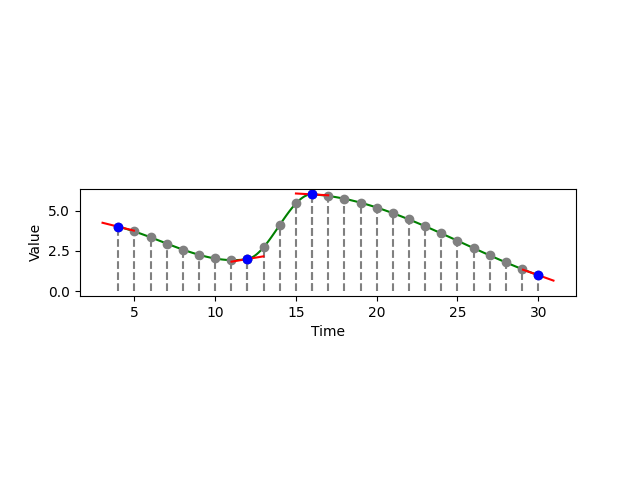

In [51]:
keytimes = np.array([4, 12, 16, 30])
keyvalues = np.array([4, 2, 6, 1])

fig28, (ax32) = plt.subplots(1, 1)

cardinal_pts = np.column_stack([keytimes, keyvalues])
cardinal_pts = np.concatenate([cardinal_pts[0:1], cardinal_pts, cardinal_pts[-1:]])
p_to_hermite = cardinal_to_hermite(cardinal_pts, 0)
p_to_hermite = p_to_hermite[:, 1] / (p_to_hermite[:, 0]+1e-8)  ## <---- Tension factor is useless
p_to_hermite[::2] = keyvalues

scales = keytimes[1:] - keytimes[:-1]
for i in range(3):
    pt = p_to_hermite[i*2:i*2+4].copy()
    pt[1::2] *= scales[i]
    curve = hermite(pt, np.linspace(0,1,100))
    ax32.plot(np.linspace(keytimes[i], keytimes[i+1],100), curve, '-', color='green')

for i in range(3):
    pt = p_to_hermite[i*2:i*2+4].copy()
    pt[1::2] *= scales[i]
    curve = hermite(pt, np.linspace(0,1,100))
    
    frames = np.linspace(keytimes[i], keytimes[i+1], keytimes[i+1]-keytimes[i]+1)
    framevalues = hermite(pt, np.linspace(0, 1, keytimes[i+1]-keytimes[i]+1))

    for i in range(frames.shape[0]):
        ax32.plot(frames[i], framevalues[i], 'o', color='gray')
        ax32.plot((frames[i], frames[i]), (0, framevalues[i]), '--', color='gray')

plot_tangent(ax32, p_to_hermite[1], keytimes[0], keyvalues[0])
plot_tangent(ax32, p_to_hermite[3], keytimes[1], keyvalues[1])
plot_tangent(ax32, p_to_hermite[5], keytimes[2], keyvalues[2])
plot_tangent(ax32, p_to_hermite[7], keytimes[3], keyvalues[3])
ax32.plot(keytimes, keyvalues, 'o', color='blue')


ax32.set_xlabel("Time")
ax32.set_ylabel("Value")
ax32.set_aspect('equal')

## Bezier Curve

Uniform Bezier Curve

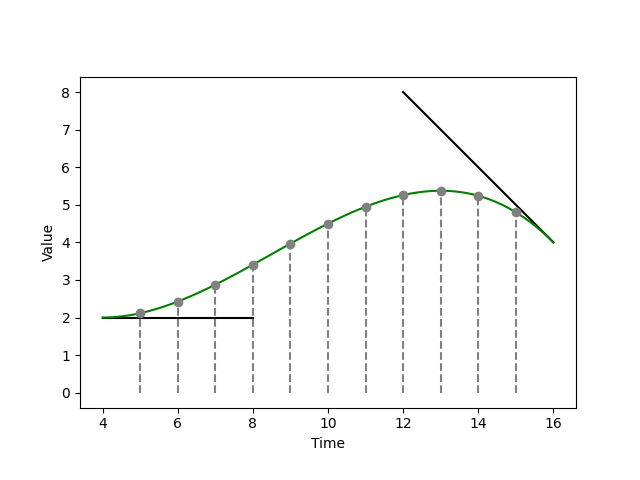

In [52]:
# uniformly spaced points
keytimes = np.array([4, 8, 12, 16])
keyvalues = np.array([2, 2, 8, 4])


fig31, (ax35) = plt.subplots(1, 1)

# compute the normalized values for the curve
t_range = keytimes[-1] - keytimes[0]

ax35.plot(keytimes[:2], keyvalues[:2], '-', color='black')
ax35.plot(keytimes[2:], keyvalues[2:], '-', color='black')

curve = bezier(keyvalues, np.linspace(0,1,100))
ax35.plot(np.linspace(keytimes[0],keytimes[-1],100), curve, 'g-')


ax34.plot(keytimes, keyvalues, 'o', color='blue')

# compute key frames
frames = np.linspace(keytimes[0], keytimes[-1], t_range+1)
curve_points = bezier(keyvalues, np.linspace(0, 1, t_range+1))[:,0]

for i in range(1,t_range):
    ax35.plot(frames[i], curve_points[i], 'o', color='gray')
    ax35.plot((frames[i], frames[i]), (0,curve_points[i]), '--', color='gray')

ax35.set_xlabel("Time")
ax35.set_ylabel("Value")
ax35.set_aspect('equal')

Non uniform bezier curve.

aka Finding Y given X.

For this we have to find which $t$ parameter will give us the keyframe we are looking for.

In [53]:
def find_bezier_root(Pts, at_x):
    M = np.array([
        [-1, 3, -3, 1], 
        [3, -6, 3, 0],
        [-3, 3, 0, 0],
        [1, 0, 0, 0]
    ])
    a,b,c,d = np.dot(M, Pts)
    roots = np.roots([a,b,c,d-at_x])
    return next((t.real for t in roots if np.isreal(t) and 0 <= t <= 1), 0)

Text(0, 0.5, 'Time')

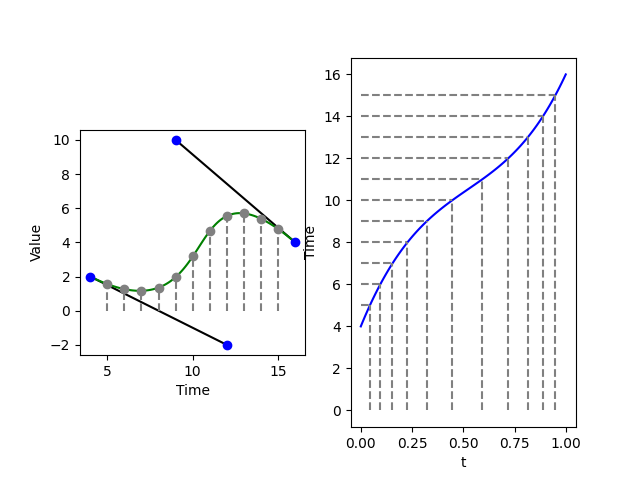

In [54]:
# non uniformly spaced points
keytimes = np.array([4, 12, 9, 16])
keyvalues = np.array([2, -2, 10, 4])


fig32, (ax36, ax37) = plt.subplots(1, 2)

bezier_pts = np.column_stack([keytimes, keyvalues])


v = (keytimes-keytimes[0]) / (keytimes[-1] - keytimes[0])

t_range = int(keytimes[-1] - keytimes[0])

ax36.plot(keytimes[:2], keyvalues[:2], '-', color='black')
ax36.plot(keytimes[2:], keyvalues[2:], '-', color='black')

curve = bezier(bezier_pts, np.linspace(0,1,100))
ax36.plot(curve[:,0], curve[:, 1], 'g-')

ax36.plot(keytimes, keyvalues, 'o', color='blue')

# show Time curve
curve = bezier(keytimes, np.linspace(0,1,100))
ax37.plot(np.linspace(0,1,100), curve[:, 0], 'b-')

# compute key frames
frames = np.linspace(keytimes[0], keytimes[-1], t_range+1)
frames_t = np.zeros([t_range-1])
for i in range(1,t_range):
    frames_t[i-1] = find_bezier_root(keytimes, i+keytimes[0])
curve_points = bezier(keyvalues, frames_t)[:, 0]

for i in range(1,t_range):
    ax36.plot(frames[i], curve_points[i-1], 'o', color='gray')
    ax36.plot((frames[i], frames[i]), (0,curve_points[i-1]), '--', color='gray')
    
    ax37.plot((frames_t[i-1], frames_t[i-1]), (0,frames[i]), '--', color='gray')
    ax37.plot((0, frames_t[i-1]), (frames[i],frames[i]), '--', color='gray')

ax36.set_xlabel("Time")
ax36.set_ylabel("Value")
ax36.set_aspect('equal')

ax37.set_xlabel("t")
ax37.set_ylabel("Time")

The formula used in the 'find_bezier_root' function when we shift $x$ to find the root in $t$.

In [55]:
x, x0, x1, x2, x3, t = sym.symbols("x x0 x1 x2 x3 t")

# bernstein basis function
xt = x0 * (1-t)**3 + 3 *x1 * (1-t)**2 * t + 3 * x2 * (1-t) * t**2 + x3 * t**3

# regroup by degree
display (xt)
display (sym.expand(xt))

# shift all points by x
xxt = sym.expand(xt).subs({x0 : (x0-x), x1 : (x1-x), x2 : (x2-x), x3 : (x3-x)})
display (xxt)
display (sym.collect(sym.expand(xxt), (t**3, t**2, t, 1)))

t**3*x3 + 3*t**2*x2*(1 - t) + 3*t*x1*(1 - t)**2 + x0*(1 - t)**3

-t**3*x0 + 3*t**3*x1 - 3*t**3*x2 + t**3*x3 + 3*t**2*x0 - 6*t**2*x1 + 3*t**2*x2 - 3*t*x0 + 3*t*x1 + x0

-t**3*(-x + x0) + 3*t**3*(-x + x1) - 3*t**3*(-x + x2) + t**3*(-x + x3) + 3*t**2*(-x + x0) - 6*t**2*(-x + x1) + 3*t**2*(-x + x2) - 3*t*(-x + x0) + 3*t*(-x + x1) - x + x0

t**3*(-x0 + 3*x1 - 3*x2 + x3) + t**2*(3*x0 - 6*x1 + 3*x2) + t*(-3*x0 + 3*x1) - x + x0

# Fit uniform cubic B Spline

Text(0, 0.5, 'Y-axis')

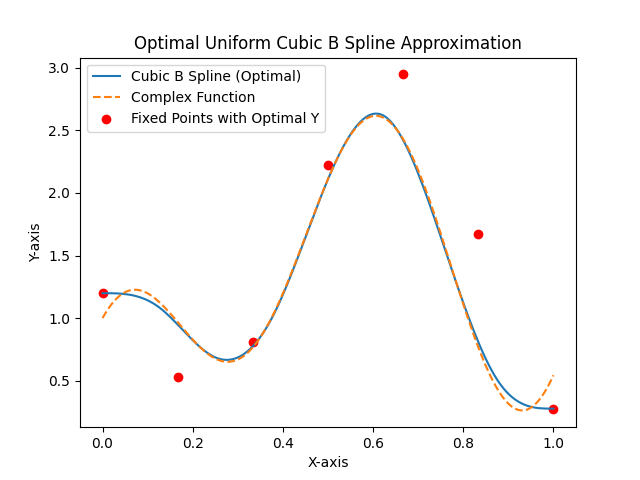

In [56]:
# Define your complex function
def complex_function(x):
    return np.sin(x) + x/2 +3*x**2 - 2*x**3 + np.cos(x*10) + np.sin(x*5)

# how many points to use between each control points
interval_count = 20

# b spline basis
BS = np.array([[-1,3,-3,1],[3,-6,0,4],[-3,3,3,1], [1,0,0,0]], dtype=np.double).T/6.0
t = np.linspace(0, 1, interval_count)
T = np.column_stack([t**3, t**2, t, np.ones_like(t)])

# compute b spline
def bspline(P):
    Pts = np.concatenate([P[0:1], P[0:1], P, P[-1:], P[-1:]])
    segment = int(Pts.shape[0]-3)
    output = np.zeros([segment*(interval_count-1)+1])
    index = 0
    for s in range(segment):
        output[index*(interval_count-1):index*(interval_count-1)+interval_count] =  np.dot(T, np.dot(BS, Pts[index:index+4])) 
        index += 1
    return output


# control points
x_points = np.linspace(0, 1, 7)

# true function data that matches all the segments from the b spline
x_actual = np.linspace(0, 1, (x_points.shape[0]+1)*(interval_count-1)+1)
y_actual = complex_function(x_actual)


# Define the error function to minimize
def error_function(y_points):

    # Evaluate the cubic b spline
    y_spline = bspline(y_points)

    # Calculate the error
    return np.sum((y_spline - y_actual)**2)


# Initial guess for the y values
initial_guess = complex_function(x_points)

# Minimize the error function to find optimal y values
result = minimize(error_function, initial_guess)

# Optimal y values
optimal_y_values = result.x

# Fit a cubic spline to the fixed x points and optimal y values
cs_optimal = bspline(optimal_y_values)

# Plotting the original function, fixed points, and the cubic spline curve
fig33, (ax38) = plt.subplots(1, 1)
ax38.plot(x_actual, cs_optimal, label='Cubic B Spline (Optimal)')
ax38.plot(x_actual, y_actual, label='Complex Function', linestyle='dashed')
ax38.scatter(x_points, optimal_y_values, label='Fixed Points with Optimal Y', color='red')
ax38.legend()
ax38.set_title('Optimal Uniform Cubic B Spline Approximation')
ax38.set_xlabel('X-axis')
ax38.set_ylabel('Y-axis')
